In [1]:
import os
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))

import json
from datetime import datetime
import requests
from requests.exceptions import BaseHTTPError
import numpy as np
import pandas as pd

import bokeh.plotting as bp
from bokeh.models import tools as bmt, ColumnDataSource

import matplotlib.pyplot as plt

from bokeh.io import output_notebook, export_png
output_notebook()

from IPython.display import Image

Loading BokehJS ...

In [2]:
BASE_DIR = f'{BASE_DIR}/HW#1'
BASE_DIR

'/Users/biplovbhandari/UAH/Fall_2021/ESS_690_Hydrology/ess-690-hydrology/HW#1'

In [3]:
def is_ed_greater_than_sd(start_date, end_date):
    """
    Checks whether the end date is greater than the start date.

    Given the start date and end date in the format 'YYYY-mm-dd', this function
    returns boolean telling if the end date is greater than the start date.

    Parameters
    ----------
    start_date : str
        The string representation of the start date in the form 'YYY-mm-dd'.
    end_date : str
        The string representation of the end date in the form 'YYY-mm-dd'.
        The end_date must be greater than the start date.
    Returns
    -------
    boolean True if end_date is greater than the start_date else boolean False
    Examples
    --------
    >>> is_greater_than = is_ed_greater_than_sd('2010-01-23', '2010-10-23')
    >>> is_greater_than
        False
    >>> is_greater_than = is_ed_greater_than_sd('2010-01-23', '2010-10-26')
    >>> is_greater_than
        True
    """

    try:
        # convert string date to date object
        sd = datetime.strptime(start_date, '%Y-%m-%d')
        ed = datetime.strptime(end_date, '%Y-%m-%d')
    except Exception as e:
        print('Error occured: ' + str(e))
        print(traceback.format_exc())
        return False

    # check if the end date is greater than the start date
    if ed > sd:
        return True

    return False

In [4]:
def get_usgs_observation(site_id, start_date, end_date):
    """
    Gets the Observation Data from the USGS Server using their API.

    Given the site_id, start date and end date, this function uses
    the API of the USGS to retrieve the observation data for the site
    and filters them temporally.

    Learn more about their API here:
    <https://waterservices.usgs.gov/rest/DV-Service.html>

    Parameters
    ----------
    site_id : str, optional
        The Site ID in the string form.
        The site information can be found here:
        <https://waterdata.usgs.gov/nwis/inventory>
    start_date : str
        The string representation of the start date in the form 'YYY-mm-dd'.
    end_date : str
        The string representation of the end date in the form 'YYY-mm-dd'.
        The end_date must be greater than the start date.
    Returns
    -------
    pandas.Series class containing the observation datasets as float with the
    datetime as the index of the Series.
    dataset.
    Examples
    --------
    >>> observations = get_usgs_observation('06730500', '2005-01-01', '2010-01-01')
    >>> observations = get_usgs_observation(site_id='06730500',
                                            start_date='2005-01-01',
                                            end_date='2010-01-01')
    """

    # check if the end date is greater than start date
    if not is_ed_greater_than_sd(start_date, end_date):
        # if not raise user input error with ValueError
        raise ValueError(
            'Either check the format of the dates string.\
            It should be \'YYYY-mm-dd\' format. \
            Or the end_date must be greater than the start_date.'
        )

    # base api url
    base_url = 'https://waterservices.usgs.gov/nwis/dv/'

    # define the request parameters
    request_params = dict(sites=site_id,
                          statCd='00003',
                          startDT=start_date,
                          endDT=end_date,
                          format='json')

    # send request
    response = requests.get(base_url, params=request_params)

    # if the request is successful
    if response.status_code == 200:
        # convert response content into json object
        observation_json = json.loads(response.content)
    else:
        raise BaseHTTPError('Error: Server Status Code {}'.format(response.status_code))

#     print(observation_json)
    # nested deep inside is our actual observation data
    observation_data = observation_json['value']['timeSeries'][0]['values'][0]['value']
    # convert into pandas df
    observation_df = pd.DataFrame(observation_data)
    # select all the data that are not provisional
    is_not_provisional = observation_df.qualifiers != 'P'
    # make a new df
    df_not_provisional = observation_df[is_not_provisional]
    # the unit of the streamflow from USGS is in cubic feet per sec
    # converting it to cubic meter per sec by multiplication factor 0.0283168
    df_not_provisional.value = df_not_provisional.value.astype(float).multiply(0.0283168)

    # get the streamflow as a Series object
    observation = pd.Series(np.array(df_not_provisional.value),
                            index=pd.to_datetime(df_not_provisional.dateTime),
                            name='observation')

    # filter by start_date and end_date
    observation = observation.iloc[(observation.index>=start_date) & (observation.index<end_date)]

    # drop any nans left over
    observation = observation.dropna()

    return observation

In [5]:
station_id = '02398300'
start_date = '1995-01-01'
end_date = '2021-01-01'
series = get_usgs_observation(station_id, start_date, end_date)


In [6]:
df = pd.DataFrame(series).reset_index()
df.columns = ['datetime', 'discharge']
df.index = pd.to_datetime(df.datetime)
df = df.set_index('datetime')
df = df.sort_index()


In [7]:
df


,discharge
datetime,
1995-01-01,11.921373
1995-01-02,11.638205
1995-01-03,11.213453
1995-01-04,10.986918
1995-01-05,10.647117
...,...
2020-12-27,24.182547
2020-12-28,20.529680
2020-12-29,17.811267


In [8]:
df.discharge.max()


359.62336

In [9]:
def initialize_fig(title: str = 'your_title',
                   x_axis_label: str = 'x_axis_label',
                   x_axis_type: str = 'auto',
                   y_axis_label: str = 'y_axis_label',
                   tools: str = 'pan,wheel_zoom,box_zoom,reset',
                   tooltips: list = [],
                   formatters: dict = {},
                   plot_height: int = 300,
                   fig_sizing_mode: str = 'scale_width',
                   ) -> bp.figure:
    # bokeh style
    TOOLS = tools
    hover_tool = bmt.HoverTool(tooltips=tooltips, formatters=formatters)

    fig = bp.figure(title=title,
                    x_axis_label=x_axis_label,
                    x_axis_type=x_axis_type,
                    y_axis_label=y_axis_label,
                    plot_height=plot_height,
                    tools=TOOLS,
                   )
    fig.add_tools(hover_tool)
    fig.sizing_mode = fig_sizing_mode

    return fig


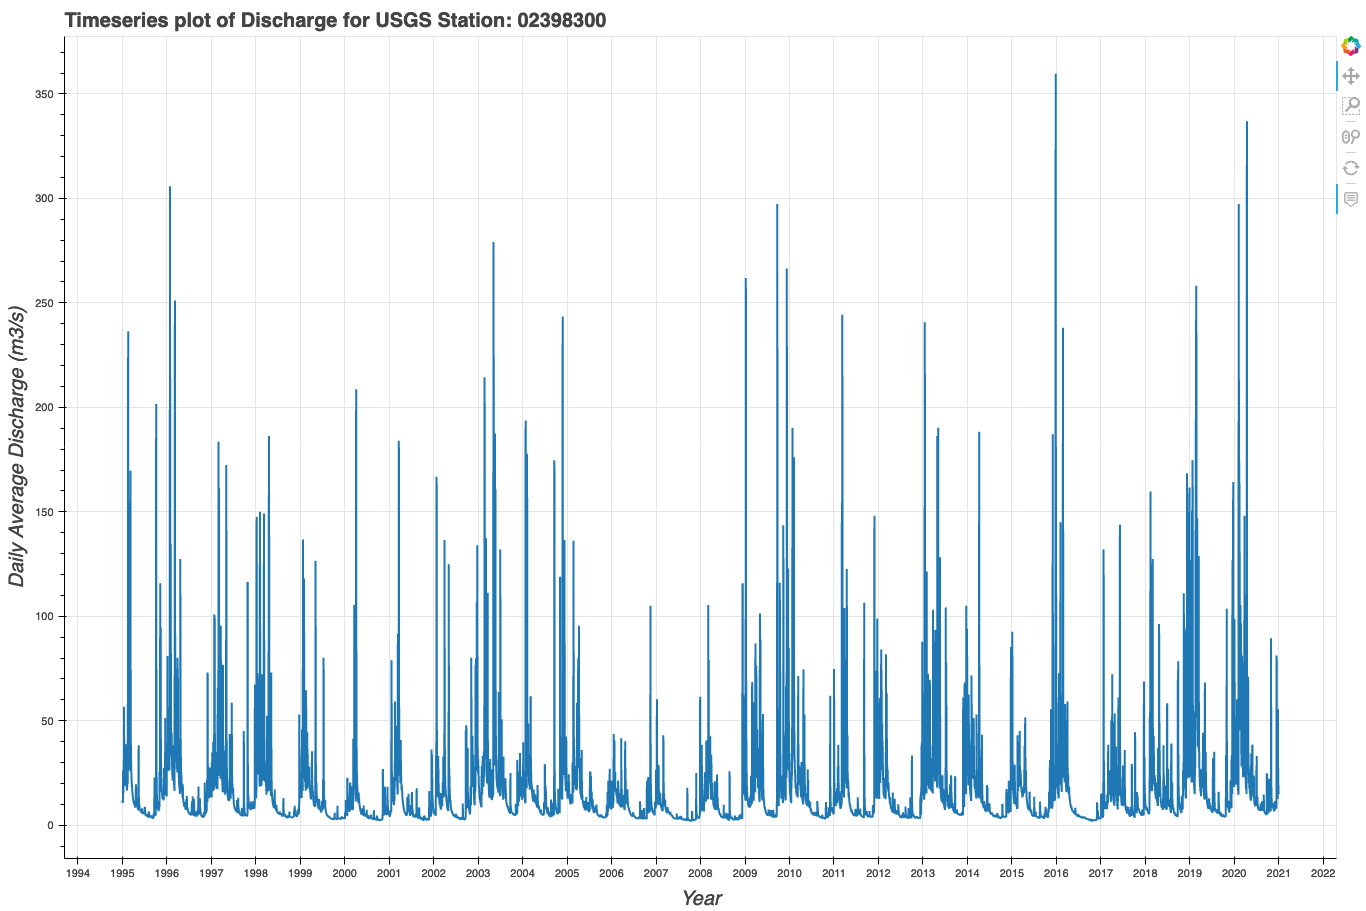

In [10]:
fig = initialize_fig(title = f'Timeseries plot of Discharge for USGS Station: {station_id}',
                     x_axis_label = 'Year',
                     x_axis_type = 'datetime',
                     y_axis_label = 'Daily Average Discharge (m3/s)',
                     tooltips = [
                         ('date',      '$x{%F}'),
                         ('discharge', '@y{0.00 a}'),
                     ],
                     formatters = { '$x' : 'datetime' },
                    )

fig.title.text_font_size = '15pt'
fig.xaxis.axis_label_text_font_size = '15pt'
fig.yaxis.axis_label_text_font_size = '15pt'
fig.xaxis.ticker.desired_num_ticks = len(np.unique(df.index.to_series().dt.year))
fig.line(df.index, df.discharge, line_width=2)

bp.show(fig)

export_png(fig, filename=f'{BASE_DIR}/discharge_vs_time.png', height=200, width=300)
Image(f'{BASE_DIR}/discharge_vs_time.png')


In [11]:
df


,discharge
datetime,
1995-01-01,11.921373
1995-01-02,11.638205
1995-01-03,11.213453
1995-01-04,10.986918
1995-01-05,10.647117
...,...
2020-12-27,24.182547
2020-12-28,20.529680
2020-12-29,17.811267


In [12]:
df2 = df.resample('1Y').mean().dropna()


In [13]:
# df2.index = df2.index.year
# df2 = df2.rename_axis('year')
df2 = df2.rename(columns={'discharge': 'annual_average'})


In [14]:
annual_peak = df.resample('1Y').max().dropna().discharge.tolist()
df2['annual_peak'] = annual_peak


In [15]:
weekly_average = df.rolling(window=7).mean().dropna()
weekly_average_annual_minimum = weekly_average.resample('1Y').min().dropna().discharge.tolist()
df2['weekly_average_annual_minimum'] = weekly_average_annual_minimum


In [16]:
df2


,annual_average,annual_peak,weekly_average_annual_minimum
datetime,,,
1995-12-31,19.153716,236.445280,3.470831
1996-12-31,22.296153,305.821440,3.956261
1997-12-31,21.078638,183.492864,4.502371
1998-12-31,19.010115,186.324544,3.721637
1999-12-31,13.261727,136.770144,2.892359
2000-12-31,9.807903,208.694816,2.479743
2001-12-31,12.466708,184.059200,2.591392
2002-12-31,16.159738,166.785952,2.762911
2003-12-31,25.302031,279.203648,4.862399


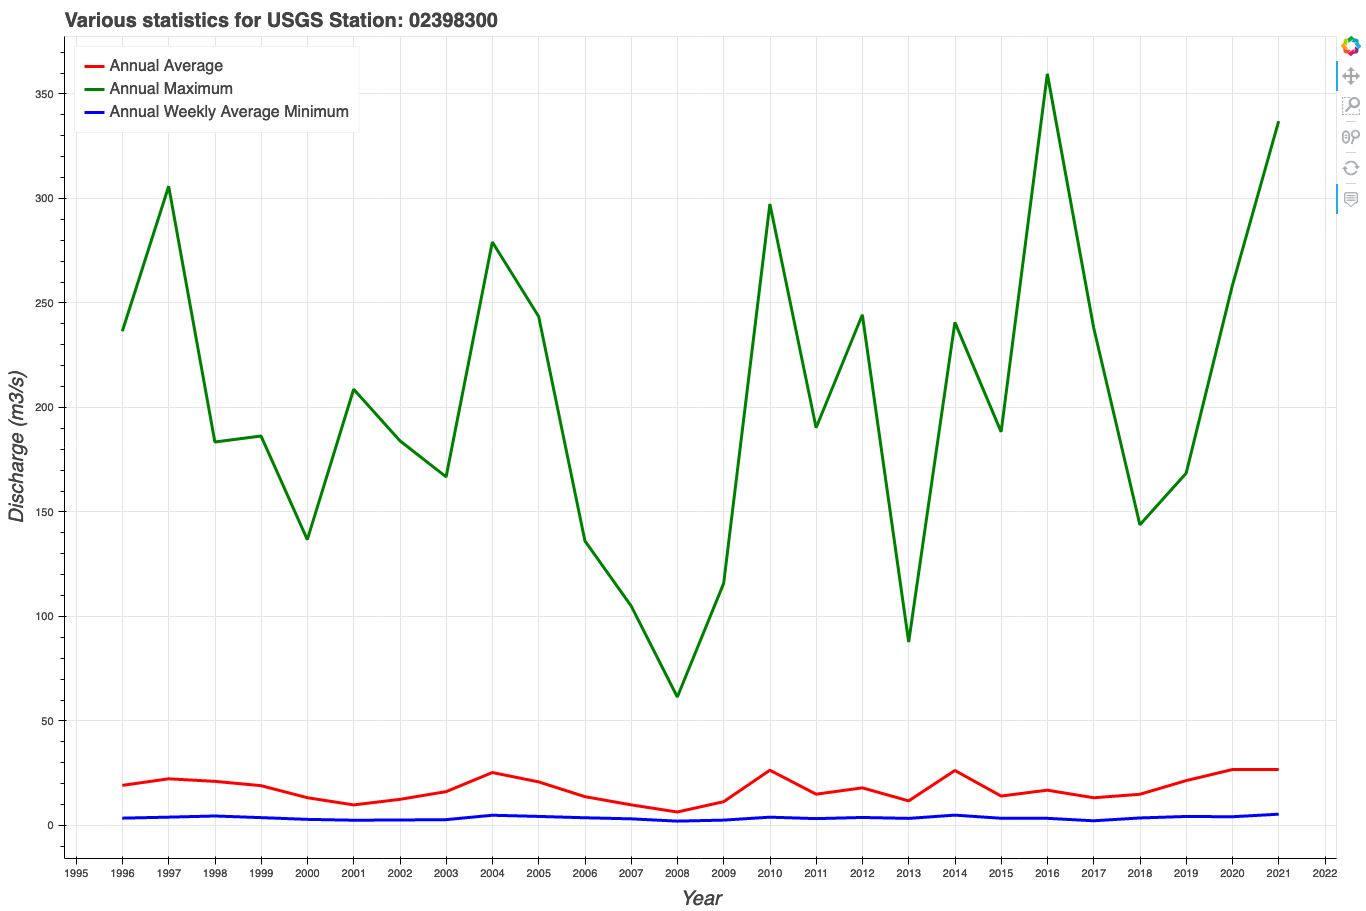

In [17]:
fig = initialize_fig(title = f'Various statistics for USGS Station: {station_id}',
                     x_axis_label = 'Year',
                     x_axis_type = 'datetime',
                     y_axis_label = 'Discharge (m3/s)',
                     tooltips = [
                         ('date',      '$x{%F}'),
                         ('discharge', '@y{0.00 a}'),
                     ],
                     formatters = { '$x' : 'datetime' },
                    )

fig.title.text_font_size = '15pt'
fig.xaxis.axis_label_text_font_size = '15pt'
fig.yaxis.axis_label_text_font_size = '15pt'
fig.xaxis.ticker.desired_num_ticks = len(np.unique(df2.index.to_series().dt.year))

fig.line(df2.index, df2.annual_average, line_width=3, line_color='red', legend_label='Annual Average')
fig.line(df2.index, df2.annual_peak, line_width=3, line_color='green', legend_label='Annual Maximum')
fig.line(df2.index, df2.weekly_average_annual_minimum, line_width=3, line_color='blue', legend_label='Annual Weekly Average Minimum')
fig.legend.location = 'top_left'
fig.legend.click_policy='hide'
fig.legend.label_text_font_size = '12pt'

bp.show(fig)

export_png(fig, filename=f'{BASE_DIR}/stats.png', height=200, width=300)
Image(f'{BASE_DIR}/stats.png')


In [18]:
df3 = df.resample('1M').mean().dropna()


In [19]:
df3


,discharge
datetime,
1995-01-31,24.867631
1995-02-28,47.131291
1995-03-31,40.622733
1995-04-30,11.675961
1995-05-31,9.868862
...,...
2020-08-31,8.185382
2020-09-30,7.373695
2020-10-31,13.466922


In [20]:
df3['month'] = df3.index.month


In [21]:
df3


,discharge,month
datetime,,
1995-01-31,24.867631,1
1995-02-28,47.131291,2
1995-03-31,40.622733,3
1995-04-30,11.675961,4
1995-05-31,9.868862,5
...,...,...
2020-08-31,8.185382,8
2020-09-30,7.373695,9
2020-10-31,13.466922,10


In [22]:
df4 = df3.groupby(['month']).mean()


In [23]:
df4


,discharge
month,
1,27.838963
2,32.596335
3,31.829348
4,24.235042
5,17.713212
6,9.300508
7,8.576020
8,5.997807
9,7.571244


In [24]:
df4.index = df4.index.map(str)
df4


,discharge
month,
1,27.838963
2,32.596335
3,31.829348
4,24.235042
5,17.713212
6,9.300508
7,8.576020
8,5.997807
9,7.571244


In [25]:
look_up = {'1': 'Jan', '2': 'Feb', '3': 'Mar', '4': 'Apr',  '5': 'May',  '6': 'Jun',
           '7': 'Jul', '8': 'Aug', '9': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

df4['month_name'] = df4.index.to_series().apply(lambda x: look_up[x])
df4


,discharge,month_name
month,,
1,27.838963,Jan
2,32.596335,Feb
3,31.829348,Mar
4,24.235042,Apr
5,17.713212,May
6,9.300508,Jun
7,8.576020,Jul
8,5.997807,Aug
9,7.571244,Sep


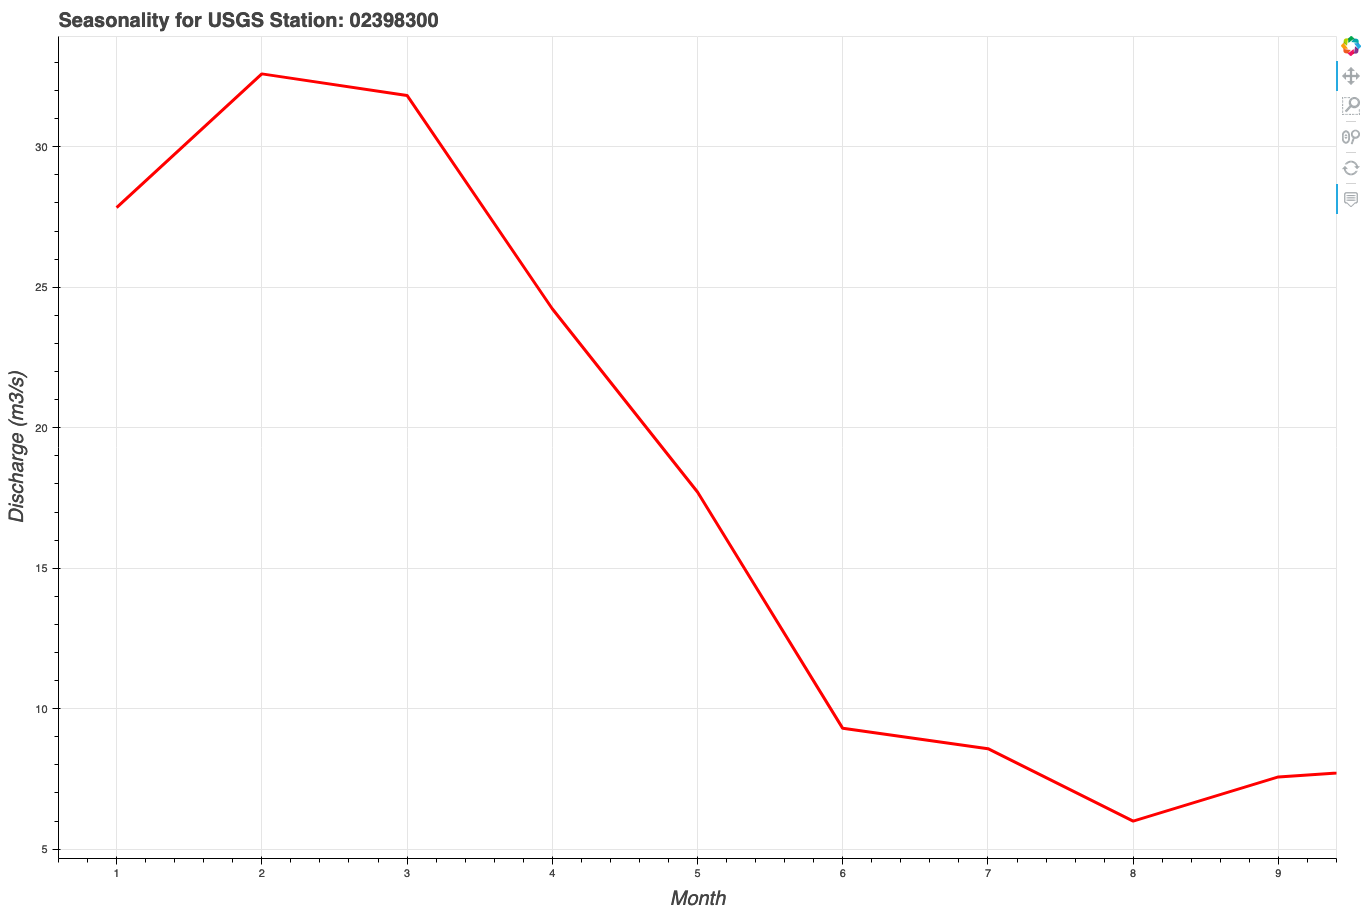

In [26]:
fig = initialize_fig(title = f'Seasonality for USGS Station: {station_id}',
                     x_axis_label = 'Month',
                     y_axis_label = 'Discharge (m3/s)',
                     tooltips = [
                         ('month',     '@x'),
                         ('discharge', '@y{0.00 a}'),
                     ],
                    )

fig.title.text_font_size = '15pt'
fig.xaxis.axis_label_text_font_size = '15pt'
fig.yaxis.axis_label_text_font_size = '15pt'
fig.xaxis.ticker.desired_num_ticks = 12

source = ColumnDataSource(data=dict(month=df4.month_name, discharge=df4.discharge, months=df4.index))

fig.line(df4.index, df4.discharge, line_width=3, line_color='red')
fig.x_range.min_interval = 1
fig.x_range.max_interval = 12

bp.show(fig)

export_png(fig, filename=f'{BASE_DIR}/seasonality.png', height=200, width=300)
Image(f'{BASE_DIR}/seasonality.png')
